
<div style="width: 650px;">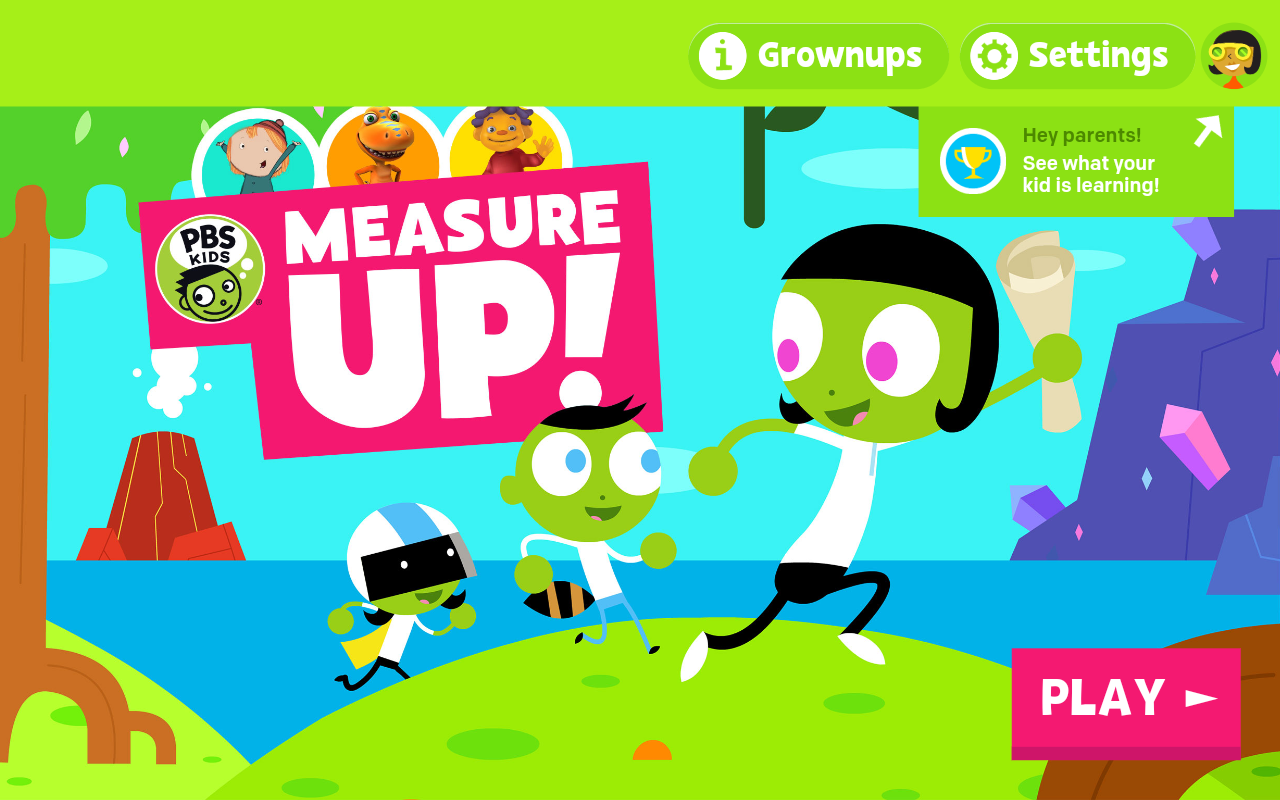</div>

# Objective of this notebook:

Explore interaction of the child with measure up and look at certain insights**

Notebook is the basis of this article on medium:
https://medium.com/@boxinthemiddle/pbs-kids-measure-up-learning-analytics-part-1-9facbdafcdb5

**[2019 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2019)**
**Uncover the factors to help measure how young children learn**


"PBS KIDS, a trusted name in early childhood education for decades, aims to gain insights into how media can help children learn important skills for success in school and life. In this challenge, you’ll use anonymous gameplay data, including knowledge of videos watched and games played, from the PBS KIDS Measure Up! app, a game-based learning tool developed as a part of the CPB-PBS Ready To Learn Initiative with funding from the U.S. Department of Education."
We are "challenged to predict scores on in-game assessments and create an algorithm that will lead to better-designed games and improved learning outcomes."

**Source of Data**

"The data used in this competition is anonymous, tabular data of interactions with the PBS KIDS Measure Up! app. Select data, such as a user’s in-app assessment score or their path through the game, is collected by the PBS KIDS Measure Up! app, a game-based learning tool." - as mentioned on Kaggle competition page.

**What is the PBS KIDS Measure Up! app?**
In the PBS KIDS Measure Up! app, children ages 3 to 5 learn early STEM concepts:
1. length, 
2. width, 
3. capacity, and 
4. weight 

while going on an adventure through three worlds:
* Treetop City, 
* Magma Peak, and 
* Crystal Caves. 

Joined by their favorite PBS KIDS characters, children can also collect rewards and unlock digital toys as they play. 

## The Problem
> For each installation_id represented in the test set, you must predict the accuracy_group of the **last assessment ** for that installation_id.

The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):

* 3: the assessment was solved on the first attempt
* 2: the assessment was solved on the second attempt
* 1: the assessment was solved after 3 or more attempts
* 0: the assessment was never solved

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
HOMEDIR = '/kaggle/input/data-science-bowl-2019'

class MODE():
    TRAINING='training' 
    TESTING='testing'
    
CURRENT_MODE = MODE.TRAINING 
#CURRENT_MODE = MODE.TESTING#

In [ ]:
#only "Bird Measurer is a different assessment code"
ASSESSMENT_TYPES = {"Cart Balancer":0, "Cauldron Filler":1, "Chest Sorter":2, "Mushroom Sorter":3, "Bird Measurer":4}
def get_assessment_type(input_string):
    for key in ASSESSMENT_TYPES.keys():
        if key in input_string:
            return ASSESSMENT_TYPES[key]

In [ ]:
import json
games_to_search = ["Cart Balancer", "Cauldron Filler", "Chest Sorter", "Mushroom Sorter"]
def get_accuracy_group(df_assess):
    df = df_assess.loc[((df_assess['event_code'] == 4100) & (df_assess['title'].str.contains('|'.join(games_to_search))) | 
                           (df_assess['event_code'] == 4110) & (df_assess['title'].str.contains('Bird Measurer')))]
    df.sort_values(by=['timestamp'])
    
    accuracy_group = -1
    attempt = 0
    for index, row in df.iterrows():
        valuation = json.loads(row['event_data'])
        assessment = valuation["correct"]
        #print(attempt)
        if assessment == True:
            if attempt == 0:
                #3: the assessment was solved on the first attempt
                accuracy_group = 3
                break
            elif attempt == 1:
                #2: the assessment was solved on the second attempt
                accuracy_group = 2
                break
            elif attempt > 1:
                #1: the assessment was solved after 3 or more attempts
                accuracy_group = 1
                break
        elif assessment == False:
            # 0: the assessment was never solved
            accuracy_group = 0

        attempt += 1
    return accuracy_group    

In [ ]:
class EventGraph_Node:
    def __init__(self, 
                 node_title, 
                 node_type, 
                 world,
                 event_count, #how many events were generated in this node
                 game_time,
                 clock_time,   #clock time spent in this node
                 df
                ):
        self.title = node_title
        #Clip, Activity, Assessment, etc
        self.type = node_type
        self.world = world
        self.event_count = event_count
        self.game_time = game_time
        
        #to be filled later     
        self.clock_time = clock_time
        #dataframe for this node
        self.df_node = df
        
        #specific to game events
        self.rounds_passed = 0
        self.rounds_missed = 0
        self.highest_round = -1
        self.highest_game_level = -1
        
    def as_dict(self):
        #return a dictionary
        return {
            'title' : self.title,
            'type' : self.type,
            'world' : self.world,
            'event_count' : self.event_count,
            'game_time' : self.game_time,
            'clock_time' : self.clock_time,
            'rounds_passed' : self.rounds_passed,
            'rounds_missed' : self.rounds_missed,
            'highest_round' : self.highest_round,
            'highest_game_level' : self.highest_game_level,
            'df_node' : self.df_node
        }
    

In [ ]:
class Installation:
    def __init__(self, installation_id, df):
        self.installation_id = installation_id
        #the dataframe of events related to this installation ID
        self.df = df
        
        #list of assessment objects in this installation
        self.assessment_obj_list = []
        
        #the index of the unfinished assessment - defaults to last one
        #for the test set, this will always be the last one
        #for the training set, we need to simulate by choosing randomly
        self.unfinished_last_assessment_idx = -1
            
        #event node graph - each node is an event title 
        #list of EventGraph_Node
        self.eventgraph = []
        self.assessment_node_idx_list = []

In [ ]:
from graphviz import Digraph

def draw_event_graph(installation_obj, graphtype=""):
    if graphtype == "png":
        dot = Digraph(format='png')
    else:
        dot = Digraph()
        
    prev_node_title = ""
    index = 0
    assessment_idx = 0
    node_count = len(installation_obj.assessment_obj_list)
    for event_node in installation_obj.eventgraph:
        #construct a string with new lines as
        node_title = "("+str(index)+")" + event_node.title + "\n"+ event_node.type + "\n" + event_node.world
        
        if event_node.type.lower() == "assessment":
            accuracy_group = ""
            #print("Assessment Idx: {0:}".format(assessment_idx))
            accuracy_group = str(installation_obj.assessment_obj_list[assessment_idx].accuracy_group)
            assessment_idx += 1
            node_title += "\naccuracy group=" + accuracy_group                
            dot.node(node_title, label=node_title, style='filled', fillcolor='red')
        elif event_node.type.lower() == "clip":
            dot.node(node_title, label=node_title, style='filled', fillcolor='green')
        elif event_node.type.lower() == "game":
            dot.node(node_title, label=node_title, style='filled', fillcolor='orange')       
        elif event_node.type.lower() == "activity":
            dot.node(node_title, label=node_title, style='filled', fillcolor='yellow')
        else:
            dot.node(node_title, label=node_title, style='filled', fillcolor='purple')

        if prev_node_title:
            #headlabel=str(game_time)
            #edge_label = "#events = "+str(event_count)+"\ntotal game time ="+str(game_time)
            edge_label = "#events = "+str(event_node.event_count)
            dot.edge(prev_node_title, node_title, label=edge_label)
            
        prev_node_title = node_title
        index += 1
        #print("drawing node")
    return dot

In [ ]:
class Assessment:
    Ideal_EventGraph = {'mushroom sorter': [{'games': ['All Star Sorting'], 
                                             'activities': ['Fireworks', 'Flower Waterer']}],
                        'bird measurer': [{'games': ['Air Show', 'Crystals Rule'],
                                           'activities': ['Crystals Rule']}],
                        'cauldron filler': [{'games': ['Scrub-A-Dub', 'Dino Drink', 'Bubble Bath'],
                                             'activities': ['Sandcastle Builder', 'Watering Hole', 'Bottle Filler']}],
                        'cart balancer': [{'games': ['Chow Time', 'Happy Camel'],
                                           'activities': ['Chicken Balancer']}],
                        'chest sorter': [{'games': ['Pan Balance'], 
                                          'activities': ['Leaf Leader', 'Egg Dropper']}]
                        }
    
    def __init__(self,
                index, 
                session_name,
                installation_id,
                assessment_events,
                assessment_time,
                did_assessment_finish
               ):
        self.assessment_index = index       
        self.session_name = session_name
        self.installation_id = installation_id
        
        self.df_assessment_events = assessment_events
        self.assessment_start_time = assessment_time
        
        #True or False
        self.did_assessment_finish = did_assessment_finish       
           
        #-----------------------------------------
        # features that are to be derived
        #-----------------------------------------
        #valid only if assessment finish
        self.accuracy_group = get_accuracy_group(assessment_events)
        #nodes that in the event graph that lead to the assessment from either start of installation_ID or 
        #from the end of last assessment - last node is the assessment title
        self.assessment_type = -1 
        self.current_level = -1
        self.prev_assessment_outcome = -1
        self.prev_assessment_type = -1
        self.prior_assessment_count = 0
        self.prev_attempts_with_0 = 0
        self.prev_attempts_with_1 = 0
        self.prev_attempts_with_2 = 0
        self.prev_attempts_with_3 = 0
             
        self.clips_played_count = 0
        self.clip_events_count = 0
        self.clips_played_time = 0
        self.lifetime_clips_played_count = 0
        self.lifetime_clip_events_count = 0
        self.lifetime_clips_played_time = 0
        
        self.games_played_count = 0
        self.games_events_count = 0
        self.games_played_time = 0
        self.lifetime_games_played_count = 0
        self.lifetime_games_events_count = 0
        self.lifetime_games_played_time = 0
        
        self.rounds_passed = 0
        self.rounds_missed = 0
        self.highest_round = -1
        self.highest_game_level = -1
        self.lifetime_rounds_missed = 0
        self.lifetime_rounds_passed = 0
        self.lifetime_highest_round = -1
        self.lifetime_highest_game_level = -1

        self.activities_played_count = 0
        self.activities_events_count = 0
        self.activities_played_time = 0
        self.lifetime_activities_played_count = 0
        self.lifetime_activities_events_count = 0
        self.lifetime_activities_played_time = 0
            
        self.prev_attempts_accuracy = {'3':0, '2':0, '1':0, '0':0, '-1':0}
        
        #ASSESSMENT_TYPES = {"Cart Balancer":0, "Cauldron Filler":1, "Chest Sorter":2, "Mushroom Sorter":3, "Bird Measurer":4}
        self.prev_attempts_of_type0 = {"3":0, "2":0, "1":0, "0":0}
        self.prev_attempts_of_type1 = {"3":0, "2":0, "1":0, "0":0}
        self.prev_attempts_of_type2 = {"3":0, "2":0, "1":0, "0":0}
        self.prev_attempts_of_type3 = {"3":0, "2":0, "1":0, "0":0}
        self.prev_attempts_of_type4 = {"3":0, "2":0, "1":0, "0":0}
        
        self.world = -1
        self.event_node_count = 0
        self.lifetime_event_node_count = 0
        
        #count of relevant games played for this assessment type
        #Mushroom assessment : "All Start Sorting"
        #Bird Measurer : "Air Show", "Crystals Rule"
        #Cauldron Filler : Scrub-A-Dub, Dino Drink, Bubble Bath, Dino Dive : 
        #Cart Balancer : Chow time, Happy Camel
        #Chest Sorter : Leaf leader, Pan Balance
        self.relevant_game_count_for_test = 0
        
        #count of relevant activities played for this assessment type
        #Mushroom assessment : Fireworks, Flower Waterer
        #Bird Measurer : Bug Measurer
        #Cauldron Filler : Watering Hole, Bottle Filler : 
        #Cart Balancer : Chicken Balancer
        #Chest Sorter : Egg Dropper
        self.relevant_acitvity_count_for_test = 0
        

In [ ]:
#analyze the training data
#There are five assessments: Bird Measurer, Cart Balancer, Cauldron Filler, Chest Sorter, and Mushroom Sorter.
#From the training set, get all the assessments from across all installation IDs.
#For each assessment, find the accuracy group
#only "Bird Measurer is a different assessment code"

def analyze_installation_data(df_, g_installation_obj_list):
    
    installation_count = 0
    valid_installation_count = 0
    df_installation_grouped = df_.groupby(['installation_id'])

    #get all the assessments across all installation IDS in this list
    assessment_count = 0
    finished_assessment_count = 0
    for name, df_installation in df_installation_grouped:
        installation_id = name
        installation_count += 1

        #Assessment attempts are captured in event_code 
        #4100 for all assessments except for Bird Measurer, which uses event_code 4110
        if CURRENT_MODE == MODE.TRAINING:
            df_assessments_per_installation = df_installation.loc[(
                #end of assessment event or start of event
               ((df_installation['event_code'] == 4100) & 
                (df_installation['title'].str.contains('|'.join(games_to_search)))) | 
               ((df_installation['event_code'] == 4110) & 
                (df_installation['title'].str.contains('Bird Measurer'))) 
                                             )]
        elif CURRENT_MODE == MODE.TESTING:
            df_assessments_per_installation = df_installation.loc[(
        #end of assessment event or start of event
               (((df_installation['event_code'] == 4100) | (df_installation['event_code'] == 2000)) & 
                (df_installation['title'].str.contains('|'.join(games_to_search)))) | 
               (((df_installation['event_code'] == 4110) | (df_installation['event_code'] == 2000)) & 
                (df_installation['title'].str.contains('Bird Measurer'))) 
                                             #| (group['type'] == "Assessment")
                                             )]

        #if df_assessments_per_installation.empty:
            #print("ERROR!! THERE ARE NO ASSESSMENT SOLUTIONS FOR THIS INSTALLATION ID : {0:}".format(installation_id))
        if not df_assessments_per_installation.empty:
            #create a installation object for this installation ID
            installation_obj = Installation(installation_id, df_installation)
    
            valid_installation_count += 1
            
            #add the installation objects to the installation list
            g_installation_obj_list.append(installation_obj)
            
    #end for
    # Observations:
    # There are 17000 installation IDs of which 3614 installation IDs have atleast one assessment event
    # We end up with 17690 asssessments across all installation IDs - which matches the df_train_labels ground truth data 
    

    #print("Total installation IDs : {0:}".format(len(df_installation_grouped)))
    #print("Total valid intallation IDs (having atleast one assessment) : {0:}".format(valid_installation_count))
    #print("Total assessments across all installation IDs : {0:}".format(assessment_count))
    #print("Total finished assessments across all installation IDs : {0:}".format(finished_assessment_count))
        

In [ ]:
#Convert timestamp strings to objects at the get-go
import datetime
#datetime.datetime.strptime(df_assess.iloc[0]['timestamp'], '%Y-%m-%dT%H:%M:%S.%fZ')
convert_time = lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ')


In [ ]:
def prepare_feature_set(installation_obj):
    #let's look at all assessments in this installation as a group to obtain features
    #compare current row to previous row.
    
    #reset things are populated here
    installation_obj.eventgraph = [] # list of event nodes in this installation
    installation_obj.assessment_node_idx_list = [] # list of assessment node indices
        
    df_install = installation_obj.df
    temp_df = df_install.copy()
    temp_df['prev_title'] = temp_df['title'].shift()
    df = temp_df.loc[(temp_df['title'] != temp_df['prev_title'])]   
    #df = df_install[(df_install['event_count'] == 1)]
    
    node_title_list = df['title'].tolist()
    node_type_list = df['type'].tolist()
    world_list = df['world'].tolist()
        
    #event count
    event_count_list = [1]
    a = df.index
    b = [(x - a[i-1]) for i,x in enumerate(a)][1:]
    event_count_list.extend(b)
    #print("Event count list : {0:}".format(event_count_list))
            
    #for wall clock time
    #convert str to timestamp
    #if (type(df_install['timestamp'].iloc[0]) == 'str'):
    df_install['timestamp'] = df_install['timestamp'].apply(convert_time)
    
    #init the assessment
    assessment_count = 0
    installation_obj.assessment_obj_list = []
        
    start_idx = 0
    last_node_idx = len(df.index) -1
    node_idx = 0
    #print(df.index)
    #print("Last index: {0:}".format(last_event_idx))
    #print("Node titles count: {0:}".format(node_title_list))
    for title, node_type, world, event_count in zip(node_title_list, 
                                                   node_type_list,
                                                   world_list,
                                                   event_count_list):
        #game time
        #caluclate game time in each event
        end_idx = start_idx + event_count
        g_time = 0
        for j in range(start_idx, end_idx):
            g_time += df_install.iloc[j].game_time
        #wall clock time is in seconds
        clock_time = df_install.iloc[end_idx]['timestamp'].timestamp() - df_install.iloc[start_idx]['timestamp'].timestamp()
         
        #df - rows for this event
        #print("Node idx: {0:}".format(node_idx))
        if node_idx < last_node_idx:
            df_event = df_install.loc[df.index[node_idx]:df.index[node_idx+1]-1]
        else:
            df_event = df_install.loc[df.index[node_idx]:]
        
        #construct event graph
        #print("Node event count: {0:}".format(event_count))
        event_node = EventGraph_Node(title, node_type, world, event_count, g_time, clock_time, df_event)      
        
        #print("Event: {0:} ; {1:}; {2:}".format(title, node_type, node_idx))
        #if this is an asessment, add it to the list
        if node_type == "Assessment":
            #print("\tAssessment Event: {0:} ; {1:}; {2:}".format(title, node_type, node_idx))
            installation_obj.assessment_node_idx_list.append(node_idx) 
            
            did_assessment_finish = False
            df_ = df_event[((df_event['event_code'] == 4100) | (df_event['event_code'] == 4110))]
            if (df_.shape[0] > 0):
                did_assessment_finish = True
                #print("Assessment finished for {0:}".format(title))
            
            #in training mode, only add if assessment finished
            if ((CURRENT_MODE == MODE.TRAINING) or # and did_assessment_finish) or
                (CURRENT_MODE == MODE.TESTING)):
                #create assessment object here..??
                assessment_obj = Assessment(assessment_count,
                                            df_event.iloc[0].game_session,
                                            installation_obj.installation_id,
                                            df_event, 
                                            df_event.iloc[0].timestamp,
                                            did_assessment_finish
                                            )         
                #print(assessment_obj_list.assessment_list[0].df_before_events)           
                installation_obj.assessment_obj_list.append(assessment_obj)
                #g_assessment_obj_list.append(assessment_obj)
                assessment_count += 1
                
        #todo - look for "Dot_GreatJob" for Activity event data
        #Get the rounds played in each "Game" and missed rounds
        #if (node_type == 'Activity'):
            #d = df_event['event_data']
            #print(df_event)
            #for row in d:
                #e_dict = json.loads(row)
                #print("Activity Using dictionary for : {0:}".format(row))
                    
        
        #Get the rounds played in each "Game" and missed rounds
        if (node_type == 'Game'):
            d = df_event['event_data']
            for row in d:
                e_dict = json.loads(row)
                #print("Using dictionary for : {0:}".format(row))
                #if (2030 == e_dict["event_code"]):
                if "misses" in e_dict.keys():
                    if 0 == e_dict["misses"]:
                        event_node.rounds_passed += 1
                    else:
                        event_node.rounds_missed += e_dict["misses"]
                if "round" in e_dict.keys() and e_dict["round"] > event_node.highest_round:       
                        event_node.highest_round = e_dict["round"]
                if "level" in e_dict.keys() and e_dict["level"] > event_node.highest_game_level:
                    event_node.highest_game_level = int(e_dict["level"])
               
        #add it to the installation object
        installation_obj.eventgraph.append(event_node)
        
        node_idx += 1 
        #end for
        
    #delete temp dataframe
    temp_df = []
    
    #print("Assessment indices list : {0:}".format(installation_obj.assessment_node_idx_list))
    print("[{0:}] Assessments in this installation : {1:}".format(installation_obj.installation_id,
                                                                  len(installation_obj.assessment_obj_list)))
    

In [ ]:
def update_assessment_objects(installation_obj):
    #update assessment ojects of installation_id
    for assessment_index, assessment_obj in enumerate(installation_obj.assessment_obj_list):
        #print("Assessment Index [{0:}] Processing on installation ID : {1:}".format(assessment_index, installation_obj.installation_id))
        #get the event node for this assessment
        node_idx = installation_obj.assessment_node_idx_list[assessment_index]
        event_node = installation_obj.eventgraph[node_idx]
        
        #set assessment type
        #1. current_assessment_type
        assessment_obj.assessment_type = get_assessment_type(event_node.title)    

        #3. number of clips, games, activities played prior to assessment
        prev_obj = None
        prev_node_idx = -1
        if (assessment_index > 0):
            prev_obj = installation_obj.assessment_obj_list[assessment_index-1]
            prev_node_idx = installation_obj.assessment_node_idx_list[assessment_index-1]
            
        #init
        #1. node count
        assessment_obj.event_node_count = node_idx - prev_node_idx -1 
        assessment_obj.lifetime_event_node_count = len(installation_obj.eventgraph)
        if prev_obj:
            assessment_obj.current_level = prev_obj.current_level
        #from node 0 (or node after last assessment) upto end current assessment eventgraph node
        eventgraph = installation_obj.eventgraph
        for i in range(prev_node_idx+1,node_idx):
            
            #find the highest level
            #2. current_level
            if ("level" in eventgraph[i].title.lower()):
                numbers = [int(i) for i in eventgraph[i].title.split() if i.isdigit()]
                if numbers[-1] > assessment_obj.current_level: 
                    assessment_obj.current_level = numbers[-1] #last number
                #print("Level is: {0:}".format(assessment_obj.current_level))
            
            if eventgraph[i].type == "Clip":
                assessment_obj.clips_played_count += 1
                #print("Clip Events: {0:}".format(eventgraph[i].event_count))
                assessment_obj.clip_events_count += eventgraph[i].event_count
                assessment_obj.clips_played_time += eventgraph[i].game_time

            if eventgraph[i].type == "Game":
                assessment_obj.games_played_count += 1
                assessment_obj.games_events_count += eventgraph[i].event_count
                assessment_obj.games_played_time += eventgraph[i].game_time

                assessment_obj.rounds_missed += eventgraph[i].rounds_missed
                assessment_obj.rounds_passed += eventgraph[i].rounds_passed
                if assessment_obj.highest_round < eventgraph[i].highest_round:
                    assessment_obj.highest_round = eventgraph[i].highest_round
                if assessment_obj.highest_game_level < eventgraph[i].highest_game_level:
                    assessment_obj.highest_game_level = eventgraph[i].highest_game_level

            if eventgraph[i].type == "Activity":
                assessment_obj.activities_played_count += 1
                assessment_obj.activities_events_count += eventgraph[i].event_count
                assessment_obj.activities_played_time += eventgraph[i].game_time


        if prev_obj:
            #init clips to prev assessment
            assessment_obj.lifetime_clips_played_count = prev_obj.lifetime_clips_played_count
            assessment_obj.lifetime_clip_events_count = prev_obj.lifetime_clip_events_count
            assessment_obj.lifetime_clips_played_time = prev_obj.lifetime_clips_played_time
            #init games to prev assessment
            assessment_obj.lifetime_games_played_count = prev_obj.lifetime_games_played_count
            assessment_obj.lifetime_games_events_count = prev_obj.lifetime_games_events_count
            assessment_obj.lifetime_games_played_time = prev_obj.lifetime_games_played_time
            assessment_obj.lifetime_rounds_missed = prev_obj.lifetime_rounds_missed
            assessment_obj.lifetime_rounds_passed = prev_obj.lifetime_rounds_passed
            assessment_obj.lifetime_highest_round = prev_obj.lifetime_highest_round
            assessment_obj.lifetime_highest_game_level = prev_obj.lifetime_highest_game_level

            #init activity to prev assessment
            assessment_obj.lifetime_activities_played_count = prev_obj.lifetime_activities_played_count
            assessment_obj.lifetime_activities_events_count = prev_obj.lifetime_activities_events_count
            assessment_obj.lifetime_activities_played_time = prev_obj.lifetime_activities_played_time

        assessment_obj.lifetime_clips_played_count += assessment_obj.clips_played_count
        assessment_obj.lifetime_clip_events_count += assessment_obj.clip_events_count
        assessment_obj.lifetime_clips_played_time += assessment_obj.clips_played_time           

        assessment_obj.lifetime_games_played_count += assessment_obj.games_played_count
        assessment_obj.lifetime_games_events_count += assessment_obj.games_events_count
        assessment_obj.lifetime_games_played_time += assessment_obj.games_played_time
        assessment_obj.lifetime_rounds_missed += assessment_obj.rounds_missed
        assessment_obj.lifetime_rounds_passed += assessment_obj.rounds_passed
        if assessment_obj.lifetime_highest_round < assessment_obj.highest_round:
            assessment_obj.lifetime_highest_round = assessment_obj.highest_round
        if assessment_obj.lifetime_highest_game_level < assessment_obj.highest_game_level:
            assessment_obj.lifetime_highest_game_level = assessment_obj.highest_game_level

        assessment_obj.lifetime_activities_played_count += assessment_obj.activities_played_count
        assessment_obj.lifetime_activities_events_count += assessment_obj.activities_events_count
        assessment_obj.lifetime_activities_played_time += assessment_obj.activities_played_time 

        #there are some installations where assessments are abandoned at the start of the event
        #which mimics the last assessment for which accuracy_group has to be predicted
        #For example: See cell above
        #In this case, we only predict for the last assessment and mark others as 0
        if assessment_obj.accuracy_group == -1 and (assessment_index < len(installation_obj.assessment_obj_list)-1):
            assessment_obj.accuracy_group = 0

        #print("Idx: {0:} ; {1:}".format(assessment_index, assessment_obj.accuracy_group))
        #if (assessment_obj.accuracy_group == -1):
            #print(assessment_obj.df_assessment_events)

        assessment_obj.prev_assessment_outcome = -1
        assessment_obj.prev_assessment_type = -1
        
        if prev_obj:
            assessment_obj.prev_assessment_outcome = prev_obj.accuracy_group 
            assessment_obj.prev_assessment_type = prev_obj.assessment_type
            
            #have to init previous attempts accuracy dictionary to the previous object for continuity 
            assessment_obj.prev_attempts_accuracy = prev_obj.prev_attempts_accuracy
            str_a = str(prev_obj.accuracy_group)
            assessment_obj.prev_attempts_accuracy[str_a] += 1

            #have to init previous attempts accuracy dictionary to the previous object for continuity 
            assessment_obj.prev_attempts_of_type0 = prev_obj.prev_attempts_of_type0
            assessment_obj.prev_attempts_of_type1 = prev_obj.prev_attempts_of_type1
            assessment_obj.prev_attempts_of_type2 = prev_obj.prev_attempts_of_type2
            assessment_obj.prev_attempts_of_type3 = prev_obj.prev_attempts_of_type3
            #ASSESSMENT_TYPES = {"Cart Balancer":0, "Cauldron Filler":1, "Chest Sorter":2, "Mushroom Sorter":3, "Bird Measurer":4}
            if prev_obj.assessment_type == 0: #Cart Balancer 
                assessment_obj.prev_attempts_of_type0[str_a] += 1
            elif prev_obj.assessment_type == 1: #Cauldron Filler
                assessment_obj.prev_attempts_of_type1[str_a] += 1
            elif prev_obj.assessment_type == 2: #Chest Sorter
                assessment_obj.prev_attempts_of_type2[str_a] += 1
            elif prev_obj.assessment_type == 3: #Mushroom Sorter
                assessment_obj.prev_attempts_of_type3[str_a] += 1
            elif prev_obj.assessment_type == 4: #Bird Measurer
                assessment_obj.prev_attempts_of_type4[str_a] += 1

        #total prior assessments
        assessment_obj.prior_assessment_count = assessment_index
        

In [ ]:
feature_columns=[   "current_assessment_type",           #1. which of the 5 assessments is this?
                    "current_level",                     #2. level of game at which assessment took place
                    #------features related to this assessment ---------
                    "clips_played_count",                #3. number of clips played prior to assessment
                    "games_played_count",                #4. number of activities played before this assessment
                    "activities_played_count",           #5.number of games played before this assessment
                    "clips_played_time",                 #6.total time of clips before assessment
                    "games_played_time",                 #7.total time of games before assessment
                    "activities_played_time",            #8.total time of activities before assessment
                    "clips_event_count",                 #9,
                    "games_event_count",                 #10
                    "activity_events_count",             #11

                    #"time_wallclock",                    #12.time spent from end of last assessment
                    #------features related to lifetime (lifetime is our defined window) ---------
                    "lifetime_clips_played_count",       #13. number of clips played 
                    "lifetime_games_played_count",       #14. number of activities played 
                    "lifetime_activities_played_count",  #15. number of games played 
                    "lifetime_clips_played_time",        #16. total time of clips 
                    "lifetime_games_played_time",        #17. total time of games 
                    "lifetime_activities_played_time",   #18. total time of activities
                    "lifetime_clip_events_count",        #19. total number of clip events
                    "lifetime_games_events_count",       #20. 
                    "lifetime_activities_events_count",  #21.

                    #"lifetime_wallclock",                #22. total wallclock gaming time for this installation ID
                    #------features related to previous assessments------
                    "prior_assessment_count",            #23. total number of prior assesssments
                    "prev_assessment_outcome",           #24. accuracy group of most recent prior assessment                                          
                    "prev_attempts_at_0",                #25. previous attempts with accuracy group 0
                    "prev_attempts_at_1",                #26.
                    "prev_attempts_at_2",                #27.
                    "prev_attempts_at_3",                #28.

                    #game rounds
                    "assessment_obj.rounds_passed",
                    "assessment_obj.rounds_missed",
                    "assessment_obj.highest_round",
                    "assessment_obj.highest_game_level", #32
                    "assessment_obj.lifetime_rounds_passed",
                    "assessment_obj.lifetime_rounds_missed",
                    "assessment_obj.lifetime_highest_round",
                    "assessment_obj.lifetime_highest_game_level",

                    "prev_assessment_type",               #33. type of previous assessment
                    "prev_attempts_at_this_type",         #34. count of prev assessments of this type
                    "prev_attempts_of_this_type_0",       #35. previous attempts of this type with accuracy group 0
                    "prev_attempts_of_this_type_1",       #36.
                    "prev_attempts_of_this_type_2",       #37.
                    "prev_attempts_of_this_type_3",        #38.
                 
                    "event_node_count",
                    "lifetime_event_node_count",
                    #------label - outcome to be predicted-------------------
                    "accuracy_group",
                   ]

In [ ]:
def construct_feature_row(last_assessment_obj):
    #construct features only for the last assessment object passed  
    df_per_install = pd.DataFrame(columns=feature_columns)
    
    a_type = last_assessment_obj.assessment_type
    str_a = str(a_type)
    print("assessment_type: {0:}".format(a_type))
    if a_type == 0: #Cart Balancer 
        this_type_prev_attempts_accuracy = last_assessment_obj.prev_attempts_of_type0
    elif a_type == 1: #Cauldron Filler
        this_type_prev_attempts_accuracy = last_assessment_obj.prev_attempts_of_type1
    elif a_type == 2: #Chest Sorter
        this_type_prev_attempts_accuracy = last_assessment_obj.prev_attempts_of_type2
    elif a_type == 3: #Mushroom Sorter
        this_type_prev_attempts_accuracy = last_assessment_obj.prev_attempts_of_type3
    elif a_type == 4: #Bird Measurer
        this_type_prev_attempts_accuracy = last_assessment_obj.prev_attempts_of_type4
        
    df_onerow = [(   last_assessment_obj.assessment_type,
                     last_assessment_obj.current_level,
                     last_assessment_obj.clips_played_count,
                     last_assessment_obj.games_played_count,
                     last_assessment_obj.activities_played_count,
                     last_assessment_obj.clips_played_time,
                     last_assessment_obj.games_played_time,
                     last_assessment_obj.activities_played_time,
                     last_assessment_obj.clip_events_count,
                     last_assessment_obj.games_events_count,
                     last_assessment_obj.activities_events_count,            #11
                     #time_wallclock,
                     #------features related to lifetime (lifetime is our defined window) ---------
                     last_assessment_obj.lifetime_clips_played_count,        #13. number of clips played 
                     last_assessment_obj.lifetime_games_played_count,        #14. number of activities played 
                     last_assessment_obj.lifetime_activities_played_count,   #15. number of games played 
                     last_assessment_obj.lifetime_clips_played_time,         #16. total time of clips 
                     last_assessment_obj.lifetime_games_played_time,         #17. total time of games 
                     last_assessment_obj.lifetime_activities_played_time,    #18. total time of activities
                     last_assessment_obj.lifetime_clip_events_count,         #19. total number of clip events
                     last_assessment_obj.lifetime_games_events_count,        #20. 
                     last_assessment_obj.lifetime_activities_events_count,   #21
                     #last_assessment_obj.lifetime_wallclock,                #22

                     last_assessment_obj.prior_assessment_count,             #23
                     last_assessment_obj.prev_assessment_outcome,            #24
                     last_assessment_obj.prev_attempts_accuracy['0'],        #25
                     last_assessment_obj.prev_attempts_accuracy['1'],        #26
                     last_assessment_obj.prev_attempts_accuracy['2'],        #27
                     last_assessment_obj.prev_attempts_accuracy['3'],        #28
                      
                     #game rounds
                     last_assessment_obj.rounds_passed,
                     last_assessment_obj.rounds_missed,
                     last_assessment_obj.highest_round,
                     last_assessment_obj.highest_game_level,  #32
                     last_assessment_obj.lifetime_rounds_passed,
                     last_assessment_obj.lifetime_rounds_missed,
                     last_assessment_obj.lifetime_highest_round,
                     last_assessment_obj.lifetime_highest_game_level,
                   
                     last_assessment_obj.prev_assessment_type,
                     this_type_prev_attempts_accuracy['0'] + this_type_prev_attempts_accuracy['1'] + this_type_prev_attempts_accuracy['2'] + this_type_prev_attempts_accuracy['3'],
                     this_type_prev_attempts_accuracy['0'],
                     this_type_prev_attempts_accuracy['1'],
                     this_type_prev_attempts_accuracy['2'],
                     this_type_prev_attempts_accuracy['3'],
                  
                     last_assessment_obj.event_node_count,
                     last_assessment_obj.lifetime_event_node_count,
                  
                     #------label - outcome to be predicted-------------------
                     last_assessment_obj.accuracy_group      #label
                     )]
    df_per_install = pd.DataFrame(df_onerow, columns=feature_columns)
    return df_per_install

In [ ]:
def construct_feature_row_for_testing(assessment_obj_list):
    #construct features only for the last assessment for which we have to predict the accuracy group 
    last_assessment_obj = assessment_obj_list[-1]
    df_per_install = construct_feature_row(last_assessment_obj)
    
    return df_per_install

In [ ]:
def construct_feature_row_for_training(assessment_obj_list):  
    df_all = pd.DataFrame(columns=feature_columns)
    #construct features for every assessment in the training set
    for assessment_obj in assessment_obj_list:
        df_per_install = construct_feature_row(assessment_obj)
        df_all = pd.concat([df_all, df_per_install])
    return df_all

In [ ]:
import csv
if CURRENT_MODE == MODE.TRAINING:
    df_specs = pd.read_csv(os.path.join(HOMEDIR,'specs.csv'))
    
    df_train_labels = pd.read_csv(os.path.join(HOMEDIR,'train_labels.csv'))
    df_train_labels.sort_values(['installation_id', 'game_session'])
    print("Truth set assessments with accuracy group - count: {0:}".format(df_train_labels.shape[0]))
    
    #df_specs
    df_train = pd.read_csv(os.path.join(HOMEDIR,'train.csv'))
    import json
    event_info_dict = {}
    event_args_dict = {}
    for index,row in df_specs.iterrows():
        event_id = row['event_id']
        event_info = row['info']
        print("Event ID [{0:}] : {1:}".format(index, event_id))
        print("Event Info : {0:}".format(event_info))
        event_info_dict[event_id] = event_info
        args_str = row['args']
        events = json.loads(args_str)
        event_args_dict[event_id] = events

        print("Args count: {0:}".format(len(events)))
        for ev in events:
            print("\tEvent Name : {0:}".format(ev['name']))
            print("\tEvent Type : {0:}".format(ev['type']))
            print("\tEvent Info : {0:}".format(ev['info']))
    
    #print(df_train.head())
elif CURRENT_MODE == MODE.TESTING:
    df_test = pd.read_csv(os.path.join(HOMEDIR,'test.csv'))
    #df_test.head()

In [ ]:
#2. analyze installation data
# Observations:
# Training data: There are 17000 installation IDs of which 3614 installation IDs have atleast one assessment event
# Testing data: There are 1000 installation IDs of which all 1000 installation IDs have atleast one assessment event 
# and atleast one unfinished assessment to be predicted. So, 1000 predictions to be done. 
if CURRENT_MODE == MODE.TRAINING:
    g_train_installation_obj_list = []
    analyze_installation_data(df_train, g_train_installation_obj_list)
    print("Total training installation IDs : {0:}".format(len(g_train_installation_obj_list)))
elif CURRENT_MODE == MODE.TESTING:
    g_test_installation_obj_list = []
    analyze_installation_data(df_test, g_test_installation_obj_list)  
    print("Total testing installation IDs : {0:}".format(len(g_test_installation_obj_list)))
                        
    

In [ ]:
#Draw the event graph for a random installation object
import random
#3461 is the random index used for the article
#1092 is the second index used for the article
random_index = 3102 #random.randint(0, len(g_train_installation_obj_list))
install_obj = g_train_installation_obj_list[random_index]

random_index

## Event Graph for this installation object

In [ ]:
prepare_feature_set(install_obj)
update_assessment_objects(install_obj)
#for training we use all assessments 
df_featureset = construct_feature_row_for_training(install_obj.assessment_obj_list)

In [ ]:
event_graph = draw_event_graph(install_obj)

#render the graph to png file
#event_graph = draw_event_graph(install_obj,'png')
#event_graph.render(filename='1092')
event_graph

## Visualizations for each installation

Let's try and answer the following questions.
1. What is the most frequented world? (insight into a favorite concept?)
2. Time spent in each world 
3. Total Time spent in clips, games, activities and assessments.
4. Change in assessment answers over time. 

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

In [ ]:
import datetime
df = pd.DataFrame([e.as_dict() for e in install_obj.eventgraph])
df['game_time'] = df['game_time']/1000000
#convert2 = lambda dt: dt.timestamp()
#df['clock_time'] = df['clock_time'].apply(convert2)
df.head()

In [ ]:
df.info()

In [ ]:
world_dict = {'TREETOPCITY' : 'TREETOPCITY (Height & Length)', 'MAGMAPEAK' : 'MAGMAPEAK (Capacity)', 'CRYSTALCAVES' : 'CRYSTALCAVES (Weight)', 'NONE' : 'WELCOME SCREEN'}
df['world'] = df['world'].map(world_dict)


### Let's look at the different types of game elements the child engages with

In [ ]:
sns.countplot(x='type', data=df)

### Let's look at the different worlds the child engages with

In [ ]:
chart = sns.countplot(x='world', data=df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(ylabel='Event count')

### Let's look at the different types of game elements in different worlds

In [ ]:
#Count of clips/games/acitivities/assessments in each world
chart = sns.countplot(x='world', hue='type', data=df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(ylabel='Event count')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

In [ ]:
chart = sns.countplot(x='type', hue='world', data=df)
chart.set(ylabel='Event count')
# Put the legend out of the figure
chart.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

### Let's look at the actual game time spent in different worlds

In [ ]:
chart = sns.barplot(x = 'world', y='clock_time', hue='type', data=df, ci=None)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(ylabel='Time spent (seconds)')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

In [ ]:
chart = sns.barplot(x = 'type', y='clock_time', hue='world', data=df, ci=None)
chart.set(ylabel='Time spent (seconds)')
# Put the legend out of the figure
chart.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

In [ ]:
df.head()

In [ ]:
chart = sns.barplot(x='world', y='rounds_passed', hue='title', data=df[df['type']=='Game'], ci=None)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
# Put the legend out of the figure
chart.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

In [ ]:
chart = sns.barplot(x='world', y='rounds_missed', hue='title', data=df[df['type']=='Game'], ci=None)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
# Put the legend out of the figure
chart.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

In [ ]:
chart = sns.barplot(x='world', y='highest_game_level', hue='title', data=df[df['type']=='Game'], ci=None)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

In [ ]:
chart = sns.barplot(x='world', y='highest_round', hue='title', data=df[df['type']=='Game'], ci=None)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

In [ ]:
agroup= []
for a in install_obj.assessment_obj_list:
    agroup.append(a.accuracy_group)
agroup

In [ ]:
df_a = df[df['type']=='Assessment']
df_a.insert(0, 'accuracy_group', agroup)
df_a

In [ ]:
chart = sns.lineplot(x=df_a.index, y='accuracy_group', data=df_a, hue='world', ci=None, marker='o')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)